### Data Exploration and cleaning

broken into subparts, 1. People dataset and 2. Cars dataset

In [ ]:
import os
import sys
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport
from tqdm import tqdm

Change seaborn settings for nicer plots

In [ ]:
sns.set(
    style='whitegrid', palette='Set2',
    rc={
        "figure.dpi": 100,
        "axes.spines.top": False,
        "axes.spines.right": False,
    },
)

In [ ]:
def show_memory_usage():
    size = {var: sys.getsizeof(obj) for var, obj in list(globals().items())}
    size = pd.DataFrame({"label": list(size.keys()), "size": list(size.values())})
    size["sizeMB"] = size['size']/(1024**2)
    return size.sort_values("size", ascending=False).reset_index(drop=True)[["label", "sizeMB"]]
show_memory_usage().head()

### People Exploration

In [ ]:
data = pd.read_parquet("1-people.parquet", index = 0)

tqdm(ProfileReport(data).to_file("people_report_historical.html"))

Check to see if the id is a unique identifier.

In [ ]:
len(data) == len(data['id'].unique()) # returns true or False. Need to inspect duplicates

In [ ]:
# Select duplicate rows except first occurrence based on all columns
duplicateRowsDF = data[data.duplicated(keep=False)]

it seems there is one duplicated row. Need to remove in order to model properly

In [ ]:
data.drop_duplicates(keep='first', inplace=True) # removes duplicates and replaces original dataframe
data.shape # lost one member, we are ok. 

In [ ]:
data.dtypes

### Plots

In [ ]:
data.hist(sharex = False, sharey = False, xlabelsize = 1, ylabelsize =1)

# density
data.plot(kind='density', subplots=True, layout=(4,4), sharex=False, legend=False,
fontsize=1)


In [ ]:
# box and whisker plots
data.plot(kind='box', subplots=True, layout=(4,4), sharex=False, sharey=False,
fontsize=12)
plt.show()

In [ ]:
freq = data.groupby("location")['id'].count()
freq.plot(kind="bar", legend=None)
plt.xlabel("Location")
plt.ylabel("Freq)")
plt.title("Urban Rural Split")

display(freq)

In [ ]:
freq = data.groupby("sex")['id'].count()
freq.plot(kind="bar", legend=None)
plt.xlabel("Gender")
plt.ylabel("Freq)")
plt.title("gender split")

display(freq)

In [ ]:
sal = data['salary']
sns.displot(sal).set(title ='Salary distribution')


Are age and income correlated to highly to include on a linear regression

In [ ]:
# Show the results of a linear regression within each dataset
sns.lmplot(x="salary", y="age", data=data, palette="muted").set(title = 'Correlation of Age and Salary')



Nope - that is odd but our data is fake so ¯\_(ツ)_/¯

## Car data

In [134]:
data = pd.read_parquet("1-cars.parquet", index = 0)

car_dict = pd.read_csv('2-cars.data.dict.csv')


# ProfileReport(data).to_file("cars_report_historical.html")

data.info() # this would be the easier way to create the data_dict

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 428 entries, 0 to 427
Data columns (total 20 columns):
vehicle_name                      428 non-null object
smallsporty_compactlarge_sedan    428 non-null int64
sports_car                        428 non-null int64
suv                               428 non-null int64
wagon                             428 non-null int64
minivan                           428 non-null int64
pickup                            428 non-null int64
awd                               428 non-null int64
rwd                               428 non-null int64
retail_price                      428 non-null int64
dealer_cost                       428 non-null int64
engine_size_(l)                   428 non-null float64
cyl                               428 non-null int64
hp                                428 non-null int64
city_mpg                          413 non-null float64
hwy_mpg                           413 non-null float64
weight                            426 no

## missingness

In [ ]:
data.isnull().any().any()

In [ ]:
sns.heatmap(data.isnull())

inspection of missing data rows

In [ ]:
null_data = data[data.isnull().any(axis=1)]
null_data

in order to see the and count the best aparatus for the encoded columns - melt them then analyze then keep or ammend

In [120]:
data.rename(columns={"smallsporty_compactlarge_sedan": "sedan"}, inplace = True)

In [123]:
data.to_csv('2-cars.data.dict.csv')

In [296]:
def extract_subtable(df, columns, label):
    """Extract a sub-table which have columns labelled with numerical indexes.
    
    Parameters
    ----------
    df : pandas dataframe
        Input dataframe holding all the columns needed to extract.
    columns : list of str
        List of columns labels to read from.
    label : str, optional
        Label for the sub-table index.
        
    Returns
    -------
    subdf : pandas dataframe
        Output dataframe and checks the length against the original data for merging
        if there is a discrepency investigate and impute
    """
    subdf = data[columns].copy(deep=True) # copy and keep
    subdf = subdf.stack() # stack
    subdf = subdf.apply(pd.to_numeric).to_frame(name = 'values')
    
    good = subdf['values'] ==1
    subdf = subdf[good]

    subdf.reset_index(drop = False, inplace = True)
    subdf.drop(columns = ['level_0', 'values'], inplace = True)
    subdf.rename(columns={"level_1": label}, inplace = True)
    
    if len(subdf) == len(data):
        print('good to merge')
    else: 
        print('length discrepency')
    
    return subdf # you have the stacked subtable

In [297]:
columns = car_dict.loc[car_dict.eval("category == 'drivetrain'"), "variable"]  #extract all of the drivetrain types from the data dictionary & keep the variable only that becomes columns
data_drivetrain = extract_subtable(data, columns, label = "drivetrain")
len(data_drivetrain)

length discrepency


202

<AxesSubplot:xlabel='drivetrain', ylabel='counts'>

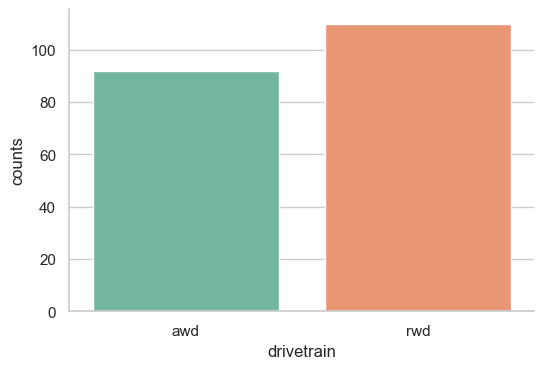

In [298]:
freq = data_drivetrain.groupby(['drivetrain']).size().reset_index(name='counts')
sns.barplot(x="drivetrain", y="counts", data=freq)